### Import Libraries

This cell imports all the necessary libraries for data handling, model building, training, and visualization.

- `os`: For interacting with the operating system to read file paths.
- `cv2`: OpenCV library for image processing.
- `numpy`: For numerical operations.
- `sklearn.model_selection`: For splitting the dataset into training and testing sets.
- `sklearn.metrics`: For evaluating the model's performance.
- `torch`: PyTorch library for building and training neural networks.
- `torch.utils.data`: For creating data loaders.
- `torch.nn`: For building neural network layers.
- `torch.optim`: For optimization algorithms.
- `matplotlib.pyplot`: For plotting graphs.
- `seaborn`: For creating visually appealing plots.
- `pandas`: For data manipulation and analysis.


In [2]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder


### Check for CUDA

This cell checks if a CUDA-enabled GPU is available and sets the device accordingly. If a GPU is available, it will use "cuda"; otherwise, it will fall back to using the CPU.

In [3]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


cpu


### Load and Preprocess Images

This function loads images and corresponding labels from the specified folders, converts images to grayscale, resizes them, and flattens them into 1D arrays.

- `dataset_folder`: Path to the folder containing the dataset.
- `img_size`: Target size to resize images.
- `os.listdir()`: Lists all files in the specified directory.
- `cv2.imread()`: Reads an image from a file.
- `cv2.cvtColor()`: Converts an image from one color space to another.
- `cv2.resize()`: Resizes an image.
- `np.array()`: Creates a NumPy array from the list of images and labels.
- `train_test_split()`: Splits arrays or matrices into random train and test subsets.
- `enumerate()`: Returns an enumerate object.
- `np.array()`: Converts lists of numerical indices to a NumPy array.



Dataset Summary:
      Label  Number of Images
0   chicken               372
1  elephant               446
2  squirrel               316

Total images: 1134
Training set size: 907
Testing set size: 227


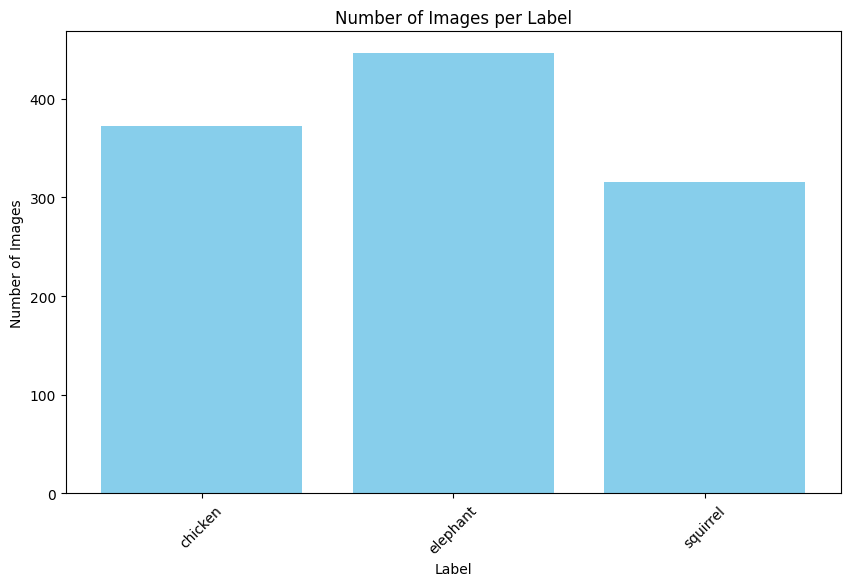

In [4]:
# Folder path
dataset_folder = 'dataset/raw-img'
img_size = (128, 128)  # Resize images to 128 x 128

def load_images_and_labels(dataset_folder, img_size):
    images = []
    labels = []
    
    for label_folder in os.listdir(dataset_folder):
        label_path = os.path.join(dataset_folder, label_folder)
        if os.path.isdir(label_path):
            label = label_folder  # Using folder names as labels
            
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                
                img = cv2.imread(img_path)
                if img is not None:  # Check if image is read successfully
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, img_size)
                    img = img.flatten()
                    images.append(img)
                    
                    labels.append(label)
        
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder, img_size)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create a summary dataframe
unique_labels, counts = np.unique(labels, return_counts=True)
summary_df = pd.DataFrame({
    'Label': unique_labels,
    'Number of Images': counts
})

# Display the summary dataframe
print("Dataset Summary:")
print(summary_df)

# Optionally, display the dataset shape and split information
print("\nTotal images:", len(images))
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

# Plotting the distribution of images per label
plt.figure(figsize=(10, 6))
plt.bar(summary_df['Label'], summary_df['Number of Images'], color='skyblue')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label')
plt.xticks(rotation=45)
plt.show()

# Convert labels to numerical indices if they are not already
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label_to_index[label] for label in y_train])
y_test = np.array([label_to_index[label] for label in y_test])


### Check and Balance the Dataset

This cell checks the distribution of classes in the training set.

- `np.unique()`: Finds the unique elements and their counts in the array.
- `dict(zip())`: Creates a dictionary from two lists.

In [5]:
# Check and balance the dataset
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"Training set distribution: {class_distribution}")

Training set distribution: {0: 287, 1: 357, 2: 263}


### Create Data Loaders

This cell defines a function to create data loaders for the training and testing sets.

- `create_data_loader(X, y, batch_size=32)`: Function to create a data loader from the given features and labels.
  - `torch.Tensor()`: Converts the input data to a PyTorch tensor.
  - `TensorDataset()`: Combines the features and labels into a dataset.
  - `DataLoader()`: Creates a data loader for batching and shuffling the dataset.
- `train_loader`: Data loader for the training set.
- `test_loader`: Data loader for the testing set.

In [6]:
# Function to create data loader
def create_data_loader(X, y, batch_size=32):
    tensor_x = torch.Tensor(X)
    tensor_y = torch.LongTensor(y)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Creating data loaders
train_loader = create_data_loader(X_train, y_train)
test_loader = create_data_loader(X_test, y_test)

print("Data loaders created successfully.")

Data loaders created successfully.


### Define Improved Neural Network

This cell defines an improved neural network class `ImprovedNN` using PyTorch's `nn.Module`. The network consists of four fully connected layers with batch normalization, ReLU activation, and dropout for regularization.

- `ImprovedNN`: A custom neural network class.
  - `__init__(self, input_size, num_classes)`: Initializes the layers of the network.
    - `nn.Linear()`: Defines a fully connected layer.
    - `nn.BatchNorm1d()`: Applies batch normalization.
    - `nn.ReLU()`: Applies the ReLU activation function.
    - `nn.Dropout()`: Applies dropout for regularization.
  - `forward(self, x)`: Defines the forward pass through the network.
    - Sequentially applies the defined layers to the input data.


In [7]:
class ImprovedNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        out = self.fc4(out)
        return out

### Evaluate Model

This cell defines a function to evaluate the model on multiple tasks.

- `evaluate_model(model, tasks)`: Evaluates the model on a list of tasks.
  - `model.eval()`: Sets the model to evaluation mode.
  - `torch.no_grad()`: Disables gradient computation for evaluation.
  - Iterates over the provided tasks, which include pairs of training and testing loaders.
  - For each batch in the test loader:
    - Moves the input data and labels to the specified device (CPU or GPU).
    - Computes the model predictions.
    - Calculates the loss using `nn.CrossEntropyLoss()`.
    - Accumulates the total loss and counts the number of correct predictions.
  - `model.train()`: Sets the model back to training mode.
  - Returns the average validation loss and the accuracy over all tasks.


In [8]:
def evaluate_model(model, tasks):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for train_loader, test_loader in tasks:
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = nn.CrossEntropyLoss()(preds, y)
                val_loss += loss.item()
                correct += (preds.argmax(dim=1) == y).sum().item()
                total += y.size(0)
    model.train()
    return val_loss / len(tasks), correct / total

### MAML Training Loop

This function implements the MAML (Model-Agnostic Meta-Learning) training loop.

- `maml_train(model, meta_optimizer, tasks, num_iterations=1000, num_inner_steps=5, inner_lr=0.01)`: Trains the model using MAML.
  - Initializes lists for tracking training and validation metrics.
  - Loops through iterations, performing inner-loop optimization on each task.
  - Computes meta-loss and updates the model using the meta-optimizer.
  - Logs and prints training and validation metrics.
  - Calls `plot_metrics` to visualize the metrics after training.

### Plot Training and Validation Metrics

This function plots the training and validation loss and accuracy.

- `plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)`: Plots the training and validation loss and accuracy over iterations.
  - `plt.subplot()`: Creates subplots for loss and accuracy.
  - `plt.plot()`: Plots the data.
  - `plt.xlabel()`, `plt.ylabel()`, `plt.legend()`, `plt.show()`: Labels and displays the plots.


In [9]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot([acc * 100 for acc in train_accuracies], label='Training Accuracy (%)')
    plt.plot([acc * 100 for acc in val_accuracies], label='Validation Accuracy (%)')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

def maml_train(model, meta_optimizer, tasks, num_iterations=1000, num_inner_steps=5, inner_lr=0.01):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for iteration in range(num_iterations):
        meta_optimizer.zero_grad()
        
        meta_loss = 0
        total_correct = 0
        total_samples = 0

        for i, (train_loader, test_loader) in enumerate(tasks):
            fast_weights = [w.clone() for w in model.parameters()]
            
            for step in range(num_inner_steps):
                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    preds = model(x)
                    loss = nn.CrossEntropyLoss()(preds, y)
                    grads = torch.autograd.grad(loss, fast_weights, create_graph=True, allow_unused=True)
                    fast_weights = [w - inner_lr * g if g is not None else w for w, g in zip(fast_weights, grads)]
                    
                    total_correct += (preds.argmax(dim=1) == y).sum().item()
                    total_samples += y.size(0)

            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = nn.CrossEntropyLoss()(preds, y)
                meta_loss += loss

        meta_loss.backward()
        meta_optimizer.step()

        # Logging training loss and accuracy
        train_losses.append(meta_loss.item())
        train_accuracy = total_correct / total_samples
        train_accuracies.append(train_accuracy)

        # Validation
        val_loss, val_acc = evaluate_model(model, tasks)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Iteration [{iteration+1}/{num_iterations}] completed, "
              f"Average Training Loss: {meta_loss.item():.4f}, "
              f"Training Accuracy: {train_accuracy:.4f}, "
              f"Average Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_acc:.4f}")
    
    # Plot metrics after training
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

### Encode Labels

This cell encodes the string labels into integer values.

- `LabelEncoder()`: Scikit-learn utility for encoding labels.
- `fit_transform(labels)`: Encodes the labels and transforms them into integers.

### Create Tasks

This function creates multiple tasks for meta-learning by splitting the data into training and testing sets for each task.

- `create_tasks(X, y, num_tasks=10, task_split=0.5)`: Creates tasks with specified number of tasks and train-test split.
  - `train_test_split()`: Splits the data into training and testing sets.
  - `create_data_loader()`: Creates data loaders for the training and testing sets.
- `tasks`: List of created tasks, each containing a pair of train and test data loaders.


In [10]:
# Encode the string labels to integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

def create_tasks(X, y, num_tasks=10, task_split=0.5):
    tasks = []
    for _ in range(num_tasks):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=task_split)
        train_loader = create_data_loader(X_train, y_train)
        test_loader = create_data_loader(X_test, y_test)
        tasks.append((train_loader, test_loader))
    return tasks

tasks = create_tasks(images, labels_encoded)

### Initialize Model and Optimizer

This cell initializes the neural network model and the optimizer for meta-learning.

- `input_size = 128 * 128`: Sets the input size based on the flattened image dimensions.
- `num_classes = 3`: Defines the number of output classes.
- `model = ImprovedNN(input_size, num_classes)`: Initializes the improved neural network with the specified input size and number of classes.
- `meta_optimizer = optim.Adam(model.parameters(), lr=0.001)`: Initializes the Adam optimizer with the model parameters and a learning rate of 0.001.

### Train Model Using MAML

This cell trains the model using the MAML (Model-Agnostic Meta-Learning) algorithm.

- `maml_train(model, meta_optimizer, tasks, num_iterations=150)`: Trains the model using MAML for 150 iterations.


c:\Users\emila\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Iteration [1/150] completed, Average Training Loss: 219.9688, Training Accuracy: 0.3147, Average Validation Loss: 126.2001, Validation Accuracy: 0.4494
Iteration [2/150] completed, Average Training Loss: 200.8738, Training Accuracy: 0.4192, Average Validation Loss: 19.0741, Validation Accuracy: 0.4691
Iteration [3/150] completed, Average Training Loss: 191.6653, Training Accuracy: 0.4432, Average Validation Loss: 18.4196, Validation Accuracy: 0.5120
Iteration [4/150] completed, Average Training Loss: 186.8378, Training Accuracy: 0.4641, Average Validation Loss: 17.4857, Validation Accuracy: 0.5750
Iteration [5/150] completed, Average Training Loss: 183.1096, Training Accuracy: 0.4892, Average Validation Loss: 16.6550, Validation Accuracy: 0.6152
Iteration [6/150] completed, Average Training Loss: 177.7396, Training Accuracy: 0.5122, Average Validation Loss: 16.1052, Validation Accuracy: 0.6261
Iteration [7/150] completed, Average Training Loss: 173.0625, Training Accuracy: 0.5355, Aver

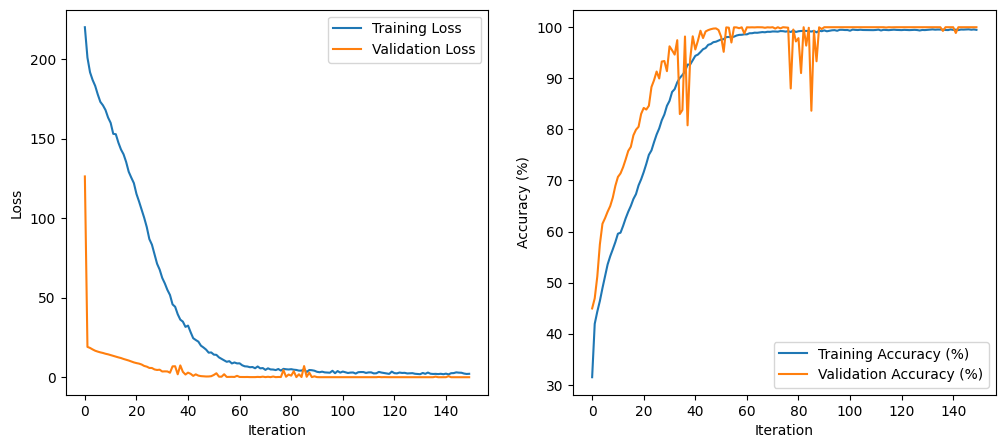

In [11]:
input_size = 128 * 128
num_classes = 3
model = ImprovedNN(input_size, num_classes)
meta_optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train using MAML
maml_train(model, meta_optimizer, tasks, num_iterations=150)

### Adapt and Evaluate Model

This function adapts the model with inner-loop optimization and evaluates it on the test set, printing the classification report and confusion matrix.

- `adapt_and_evaluate(model, train_loader, test_loader, num_inner_steps=5, inner_lr=0.01)`: Adapts the model and evaluates its performance.

### Example Usage

This cell demonstrates how to use the `adapt_and_evaluate` function with the model and data loaders.

- `adapt_and_evaluate(model, train_loader, test_loader)`: Adapts and evaluates the model.


              precision    recall  f1-score   support

     chicken       1.00      0.99      0.99        85
    elephant       1.00      1.00      1.00        89
    squirrel       0.98      1.00      0.99        53

    accuracy                           1.00       227
   macro avg       0.99      1.00      0.99       227
weighted avg       1.00      1.00      1.00       227



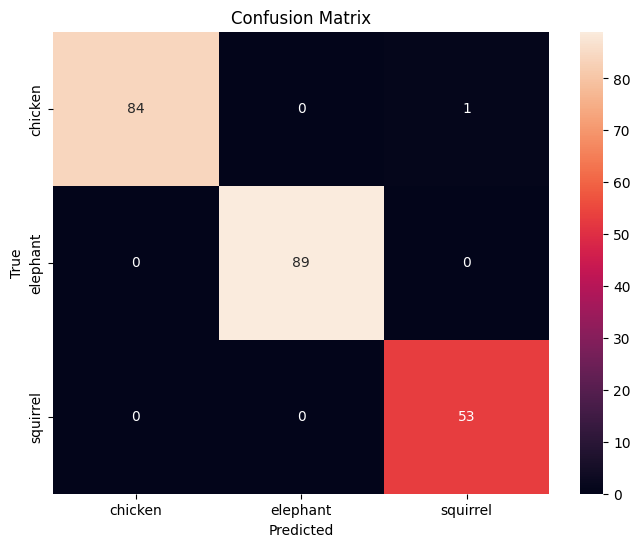

Accuracy: 99.56%
Total labels of each class: {'chicken': 85, 'elephant': 89, 'squirrel': 53}


In [12]:
# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def adapt_and_evaluate(model, train_loader, test_loader, num_inner_steps=5, inner_lr=0.01):
    model.to(device)
    fast_weights = [w.clone() for w in model.parameters()]
    for step in range(num_inner_steps):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = nn.CrossEntropyLoss()(preds, y)
            grads = torch.autograd.grad(loss, fast_weights, allow_unused=True)
            fast_weights = [w - inner_lr * g if g is not None else w for w, g in zip(fast_weights, grads)]
    
    all_preds = []
    all_labels = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        all_preds.extend(preds.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    
    label_names = label_encoder.classes_  # Using the label encoder to get the correct label names
    print(classification_report(all_labels, all_preds, target_names=label_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy
    accuracy = (np.trace(cm) / float(np.sum(cm))) * 100
    print(f'Accuracy: {accuracy:.2f}%')

    # Print total labels of each class
    total_labels = dict(zip(label_names, np.sum(cm, axis=1)))
    print(f'Total labels of each class: {total_labels}')

# Example usage
adapt_and_evaluate(model, train_loader, test_loader)

### Display Random Predictions

This function displays a specified number of randomly selected images along with their true and predicted labels.

- `show_random_predictions(model, test_loader, num_images=25)`: Displays 25 random predicted images from the test set.

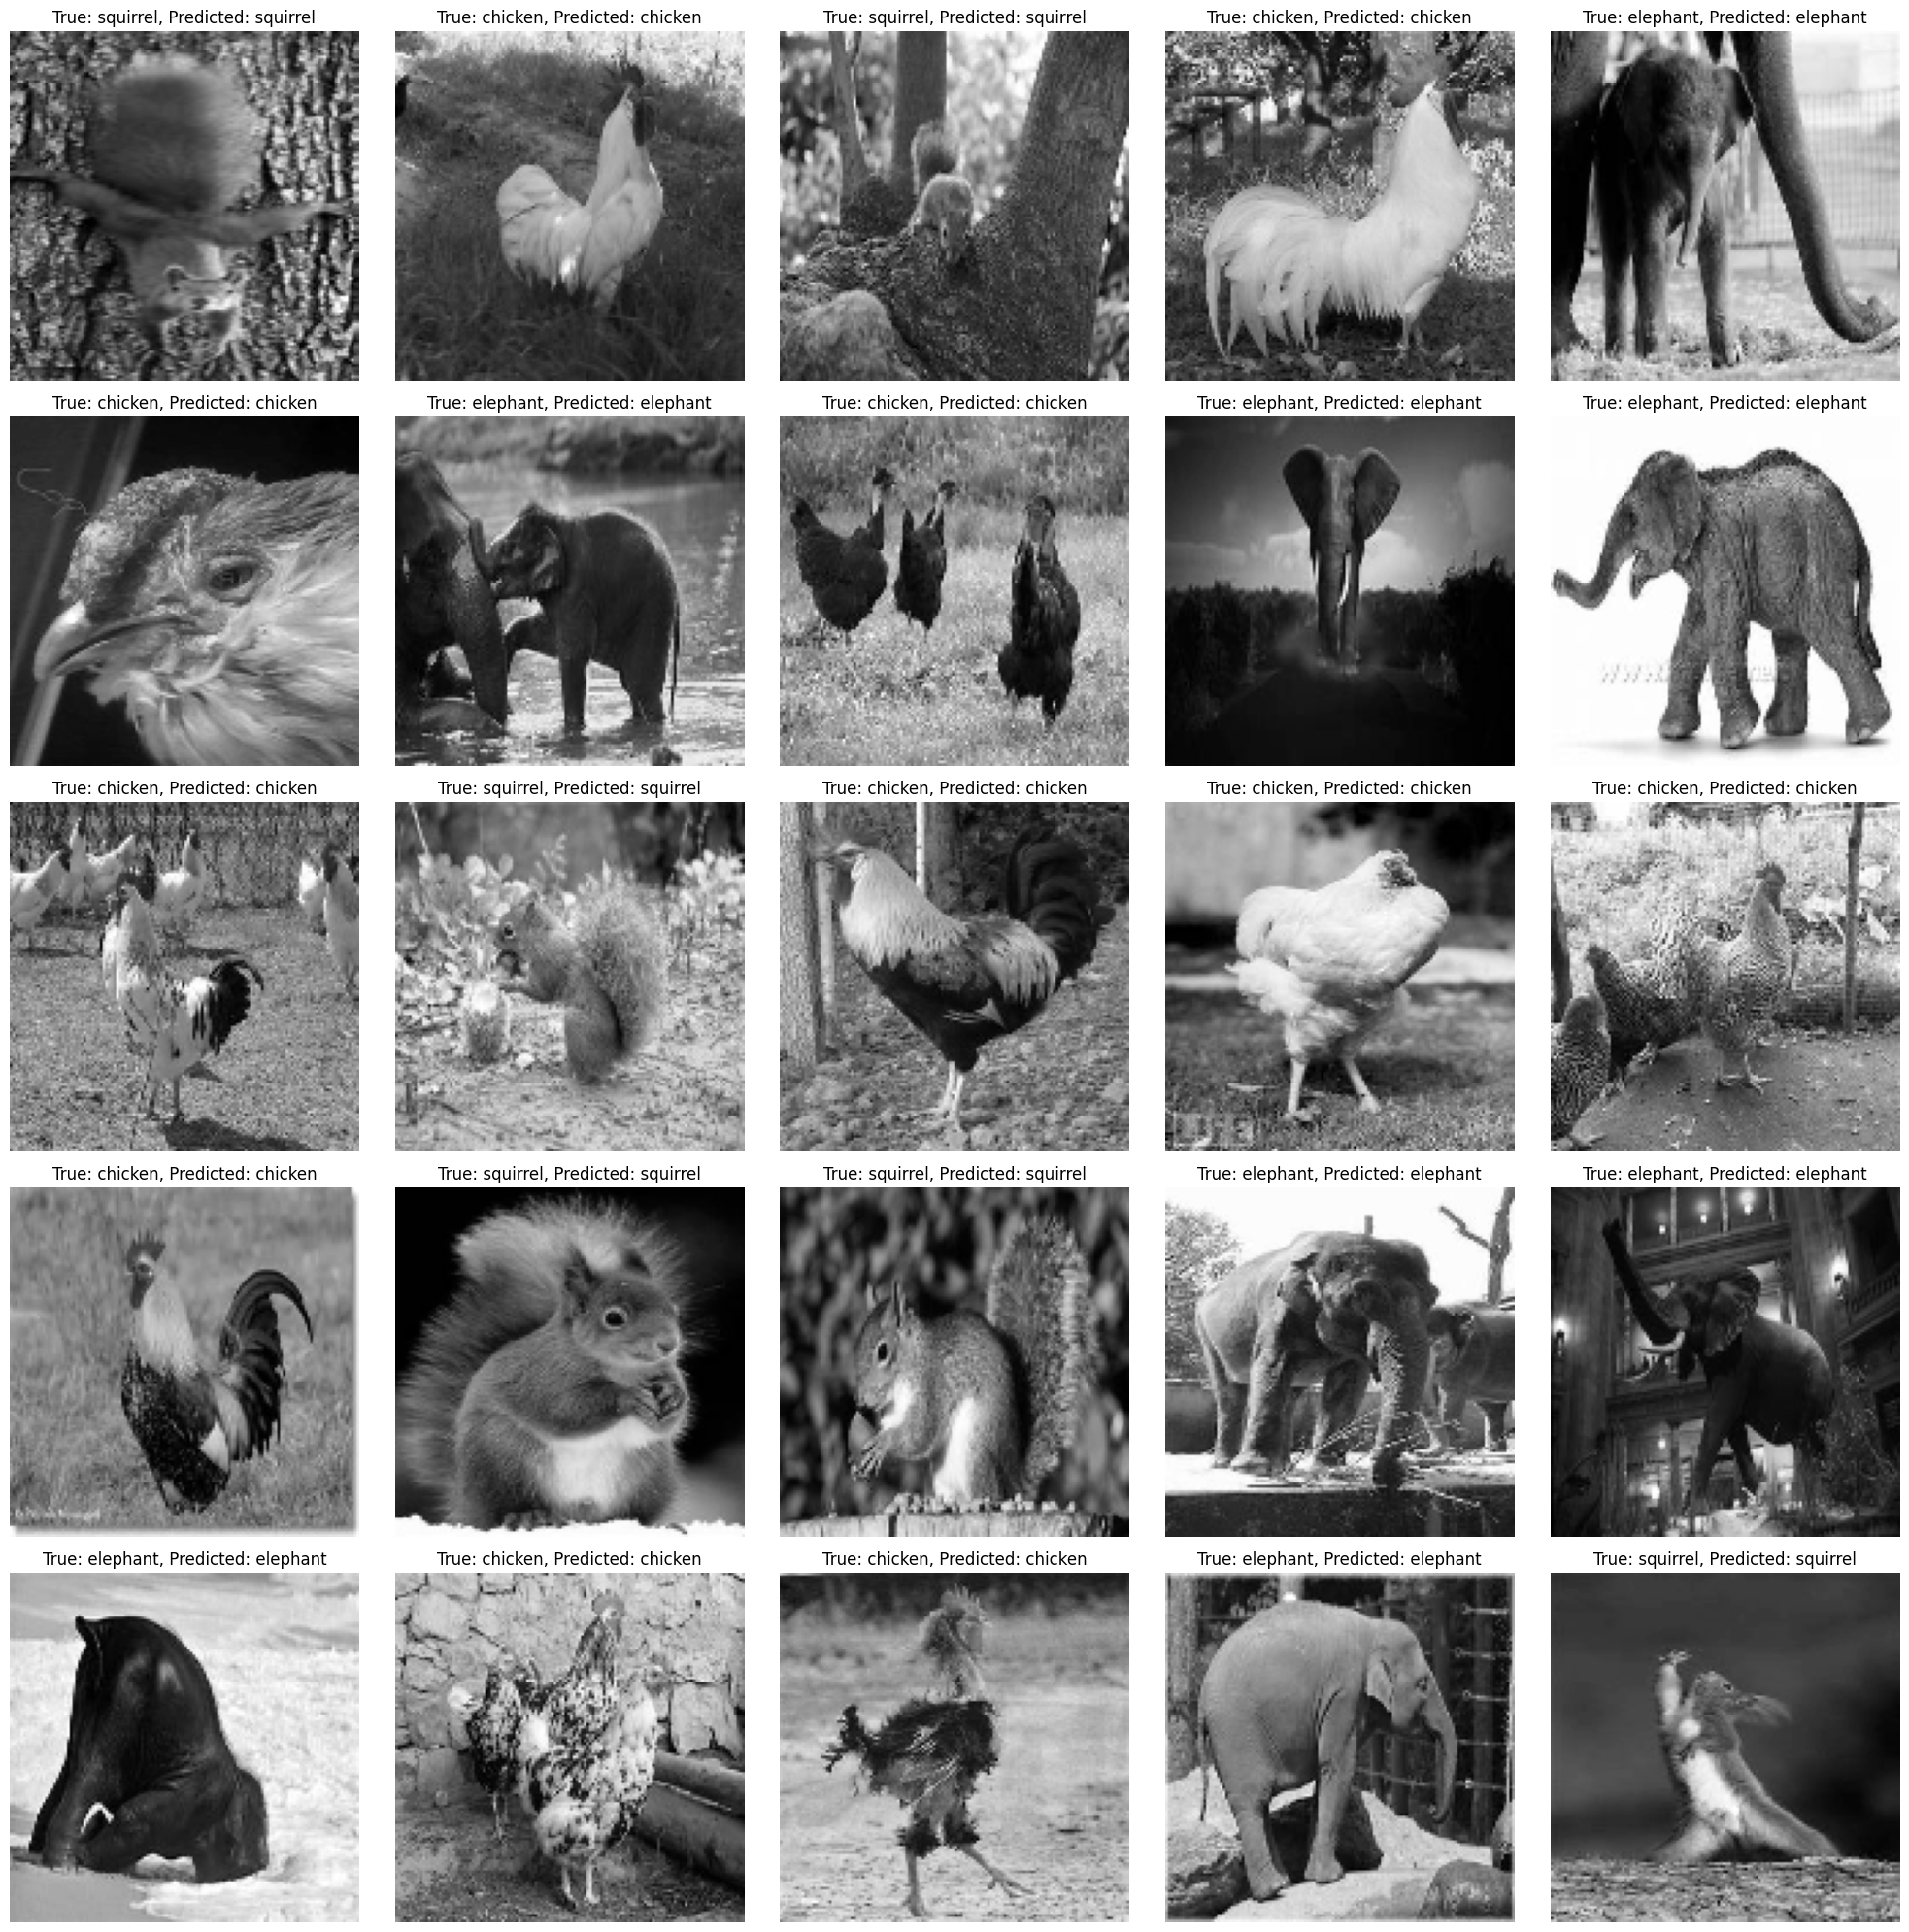

In [13]:
# Function to randomly display a specified number of predicted images
def show_random_predictions(model, test_loader, num_images=25):
    model.eval()
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    axs = axs.flatten()
    
    class_names = label_encoder.classes_  # Use the label names from the label encoder
    displayed_images = 0

    # Collect all predictions
    all_images = []
    all_preds = []
    all_true_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x.to(device))
            all_images.extend(x.cpu().numpy())
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_true_labels.extend(y.cpu().numpy())
    
    # Shuffle the indices to select random images
    indices = list(range(len(all_images)))
    random.shuffle(indices)
    
    for i in range(num_images):
        idx = indices[i]
        img = all_images[idx].reshape(128, 128)
        true_label = all_true_labels[idx]
        predicted_label = all_preds[idx]
        
        # Display the image
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}")
        axs[i].axis('off')
        
    plt.tight_layout()
    plt.show()

# Call the function to display random predictions
show_random_predictions(model, test_loader)